## **Desafio de Ciencia de Dados - Data & Analytics**

- por Felipe Cunha 

### Contexto e Objetivos: 

- A partir de dados de consumo de energia elétrica de uma empresa de aço, produtora de bobinas, placas, etc. **Prever o consumo de energia elétrica mensal dessa empresa.**
- Os dados foram coletados na nuvem durante o período de 1 ano e coletados de intervalos de 15 minutos.

### Dados: 

| Nome          | Description.                                         | Tipo Variável | 
|---------------|------------------------------------------------------|---------------|
| Data          | Data de registro do consumo                          | Continua      |
| Energia_usada | Consumo de energia da empresa [kWh]                  | Continua      |
| V1            | Corrente atrasada [kVarh]                            | Continua      |
| V2            | Corrente principal [kVarh]                           | Continua      |
| V3            | Medições de C02 [ppm]                                | Continua      |
| V4            | Fator de potência atual atrasado                     | Continua      |
| V5            | Fator de potência atual principal                    | Continua      |
| V6            | Número de segundos a partir da meia-noite [S]        | Continua      |
| V7            | Estado da semana (Final de semana ou dia da semana)  | Categorica    |
| V8            | Dia da semana (Terça-feira, Sábado, etc)             | Categorica    |
| V9            | Tipo de carga (Carga leve, Carga média, Carga máxima) | Categorica    | 

In [1]:
# importando bibliotecas 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

rcParams.update({"figure.figsize" : (12.8,9.6)})

In [2]:
# carregando dataframe e olhando a estrutura dos dados

df = pd.read_csv('dataset.csv')
df.head()

,Data,Energia_usada,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Dia da Semana,Segunda-feira,Carga leve
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Dia da Semana,Segunda-feira,Carga leve
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Dia da Semana,Segunda-feira,Carga leve
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Dia da Semana,Segunda-feira,Carga leve
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Dia da Semana,Segunda-feira,Carga leve


In [3]:
df.shape

(35040, 11)

In [3]:
# Transformandos labels e os dados que são strings para o formato de data e em um padrão para facilitar as análises posteriores

df.columns = df.columns.str.lower() 

df['data'] = pd.to_datetime(df['data']) 
df['dia'] = df['data'].dt.day
df['semana'] = df['data'].dt.week 
df['mes'] = df['data'].dt.month
df.loc[34944:, 'semana'] = 53 # correção da última semana

# Modificando os valores das colunas categóricas para lower case e retirando espaços
# Definindo a função que será aplicada em cada elemento
def lowercase_replace_space(x):
    if isinstance(x, str):
        return x.lower().replace(' ', '_').replace('-', '_')
    else:
        return x

# Aplicando a função em todos os elementos do dataframe que sejam do formato objeto
df = df.applymap(lowercase_replace_space)

C:\Users\felip\AppData\Local\Temp\ipykernel_4676\2299148169.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['semana'] = df['data'].dt.week


In [67]:
# Verificando como ficaram os dados após os tratamentos
df.head()

,data,energia_usada,v1,v2,v3,v4,v5,v6,v7,v8,v9,dia,semana,mes
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,dia_da_semana,segunda_feira,carga_leve,1,1,1
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,dia_da_semana,segunda_feira,carga_leve,1,1,1
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,dia_da_semana,segunda_feira,carga_leve,1,1,1
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,dia_da_semana,segunda_feira,carga_leve,1,1,1
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,dia_da_semana,segunda_feira,carga_leve,1,1,1


- Importante mencionar que as variáveis categórias foram analisadas quanto a presença de dados anômalos antes de se iniciar as próximas análises

#### Primeiro será feita uma análise na variável *target* "energia_usada"

In [68]:
df['energia_usada'].describe()

count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: energia_usada, dtype: float64

- Percebe-se que a média de gasto energético é de 27.39 Kwh;
- Mínimo 0 Kwh, ou seja, momentos em que os equipamentos estão desligados; 
- Máximo de 157.18 Kwh; 

É interessante observar a distribuição dos dados dessa variável; 

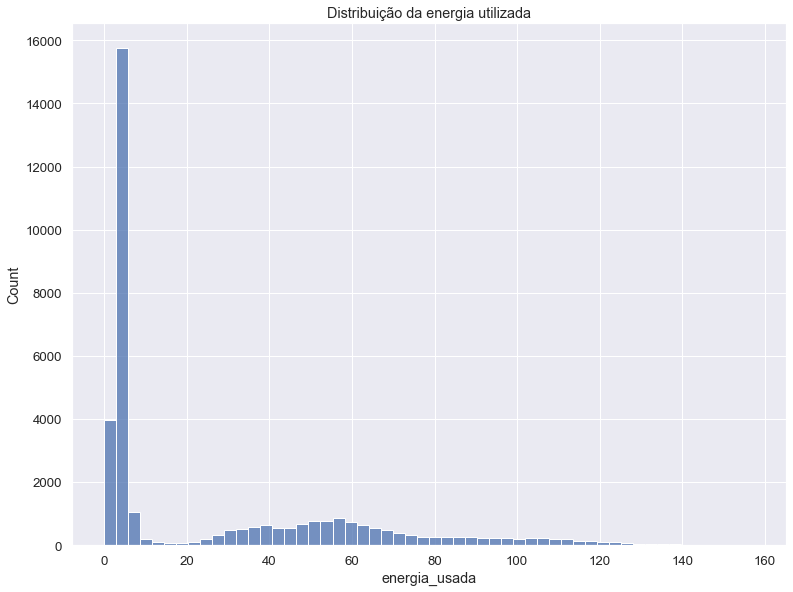

In [69]:
sns.histplot(df['energia_usada'])
plt.title('Distribuição da energia utilizada')
plt.show()

- Analisando-se a distribuição dos valores, percebe-se que há uma grande quantidade em torno de 0-10 Kwh, isso pode estar relacionado a momentos em que a fábrica não está operando com suas linhas de produção
- Assim, pode ser interessante excluir essa região para ter uma visão diferente do comportamento da variável

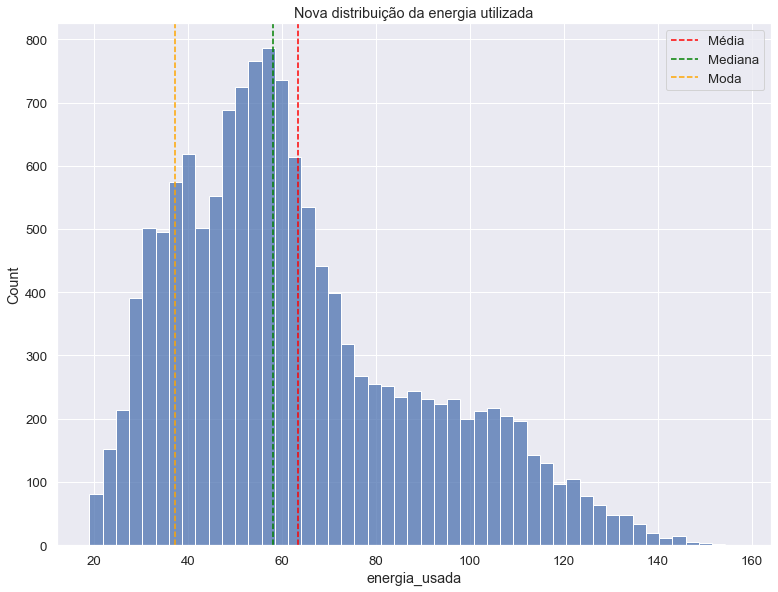

In [70]:
energia_maior_19 = df[df['energia_usada'] > 19] # Excluindo os dados de baixo consumo energético; 

media = energia_maior_19.energia_usada.mean()
mediana = energia_maior_19.energia_usada.median()
moda = float(energia_maior_19.energia_usada.mode())

sns.histplot(energia_maior_19['energia_usada']) # novo histograma

plt.axvline(x=media, color='red', linestyle='--', label='Média')
plt.axvline(x=mediana, color='green', linestyle='--', label='Mediana')
plt.axvline(x=moda, color='orange', linestyle='--', label='Moda')
plt.title('Nova distribuição da energia utilizada')
plt.legend()
plt.show()

In [71]:
print(f'A distribuição segue uma assimetria positiva, com média {media:.2f} Kwh, mediana {mediana:.2f} Kwh e moda {moda:.2f} Kwh.')

A distribuição segue uma assimetria positiva, com média 63.42 Kwh, mediana 58.03 Kwh e moda 37.33 Kwh.


- Em seguida, foram analisados a presença ou não de outliers através de boxplot; 

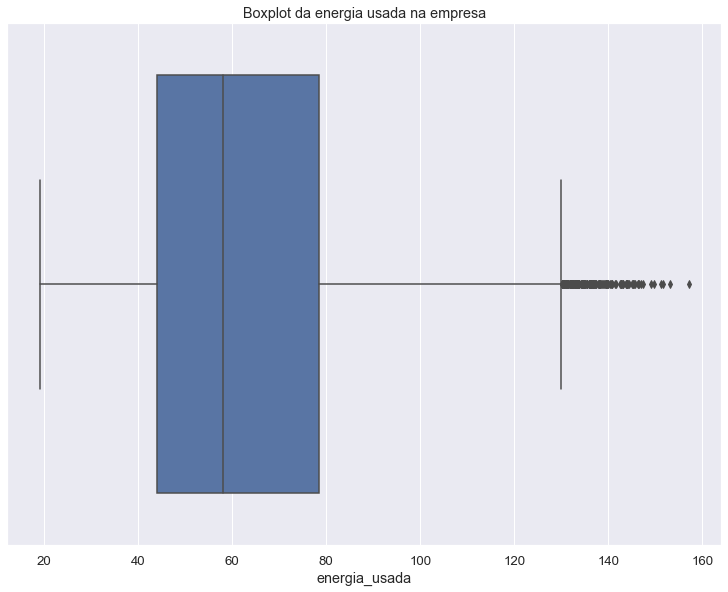

In [72]:
sns.boxplot(x=energia_maior_19['energia_usada'])
plt.title('Boxplot da energia usada na empresa')
plt.show()

- Percebe-se a presença de outliers e então criou-se um conjunto de dados com esses outliers visando entender melhor seu comportamento

In [73]:
# Cálculo dos percentis, IQR e definição de quais amostras estão se comportando como outlier
q1 = np.percentile(df['energia_usada'], 25)
q3 = np.percentile(df['energia_usada'], 75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
outliers = df[df['energia_usada'] > ls]

In [74]:
print(f'Pelo cálculo do limite superior do boxplot, o qual foi de {ls:.2f} Kwh, então valores acima desse, serão considerados outliers.')

Pelo cálculo do limite superior do boxplot, o qual foi de 123.29 Kwh, então valores acima desse, serão considerados outliers.


- Para verificar se há alguma relação dos outliers com as outras variáveis ao longo dos meses, serão analisados agrupamentos desses valores em função do mês, do dia da semana e do tipo de carga.

In [75]:
outliers.groupby('mes')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5', 'dia']].mean()

,energia_usada,v1,v2,v3,v4,v5,dia
mes,,,,,,,
1,134.241500,57.490333,0.0,0.062000,91.871000,100.0,21.650000
2,131.531842,60.867632,0.0,0.044211,90.634211,100.0,15.000000
3,132.529524,59.164286,0.0,0.060952,91.228571,100.0,17.333333
4,131.344091,58.502273,0.0,0.060455,91.180000,100.0,9.909091
5,129.914545,59.552121,0.0,0.060909,90.824242,100.0,9.545455
6,126.637000,57.082000,0.0,0.060000,91.051000,100.0,3.300000
7,129.132500,60.265000,0.0,0.060000,90.570000,100.0,4.500000
8,133.287143,61.532857,0.0,0.060952,90.661429,100.0,3.476190
9,129.138947,55.655789,0.0,0.060000,91.690000,100.0,3.842105


In [76]:
outliers.groupby('v8')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean()

,energia_usada,v1,v2,v3,v4,v5
v8,,,,,,
quarta_feira,130.594516,59.324839,0.0,0.060645,90.945968,100.0
quinta_feira,132.663297,61.973956,0.0,0.060879,90.513297,100.0
sabado,129.096000,63.454000,0.0,0.060000,89.736000,100.0
segunda_feira,132.671600,60.962200,0.0,0.061400,90.785200,100.0
sexta_feira,131.701429,56.895179,0.0,0.061071,91.714107,100.0
terca_feira,130.032344,57.916875,0.0,0.050937,91.233125,100.0


In [77]:
outliers.groupby('v9')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean()

,energia_usada,v1,v2,v3,v4,v5
v9,,,,,,
carga_leve,130.217576,68.290000,0.0,0.060000,88.453636,100.0
carga_maxima,131.771678,61.506040,0.0,0.059799,90.532081,100.0
carga_media,131.605959,55.876644,0.0,0.057945,91.986027,100.0


- Percebe-se que não há uma relação dessa alta energia usada com algum mês específico, dia da semana (apenas não se tem dados aos domingos) e carga.
- Quanto ao dia da semana, nos três primeiros meses esses picos energéticos foram registrados na terceira semana do mês (jan-mar), depois na segunda semana (abr-mai), na primeira semana (jun-set) e depois segunda semana novamente (out-dez); 
- Há também a questão da corrente principal ser zero e o fator de potência principal ser zero. Isso indica que a fábrica não estava em funcionamento nesse período e muito provavelmente esses valores são anômalos.

- Em seguida serão analisadas as relações entre as outras variáveis e a variável *target*

In [78]:
energia_maior_19 = energia_maior_19[energia_maior_19['energia_usada'] <= ls] # Dataframe sem outliers e sem os valores menores que 20 que é quando a fábrica não está operando

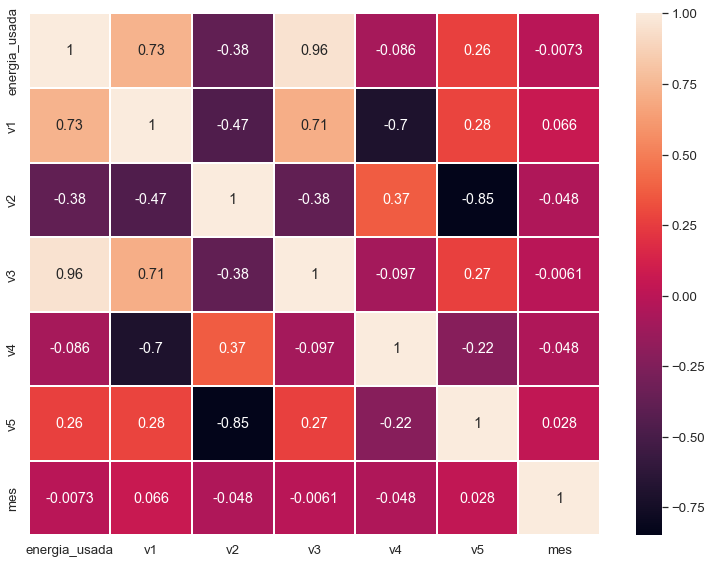

In [79]:
# Criando um mapa de calor para analisar a correlação entre as variáveis numéricas
cols_to_plot1 = ['energia_usada', 'v1', 'v2', 'v3', 'v4', 'v5', 'v7', 'v8', 'v9', 'mes']
sns.set(font_scale=1.2)
sns.heatmap(energia_maior_19[cols_to_plot1].corr(numeric_only=True), annot=True, linewidth=.3)
plt.show()

- Percebe-se que há uma **correlação positiva** entre a *energia usada* e as *emissões de gás carbônico (CO2)* como é esperado; 
- Também existe uma **correlação positiva** entre a *energia usada* e a *corrente atrasada (v1)*;
- Em relação as outras variáveis, existe uma **correlação negativa** entre a *corrente atrasada (v1)* e o *fator de potência atrasado (v4)*; 
- Além disso há uma **correlação negativa** também entre a *corrente principal (v2)* e o *fator de potência principal (v5)*; 
---
Se aprofundando agora em torno das variáveis categóricas:

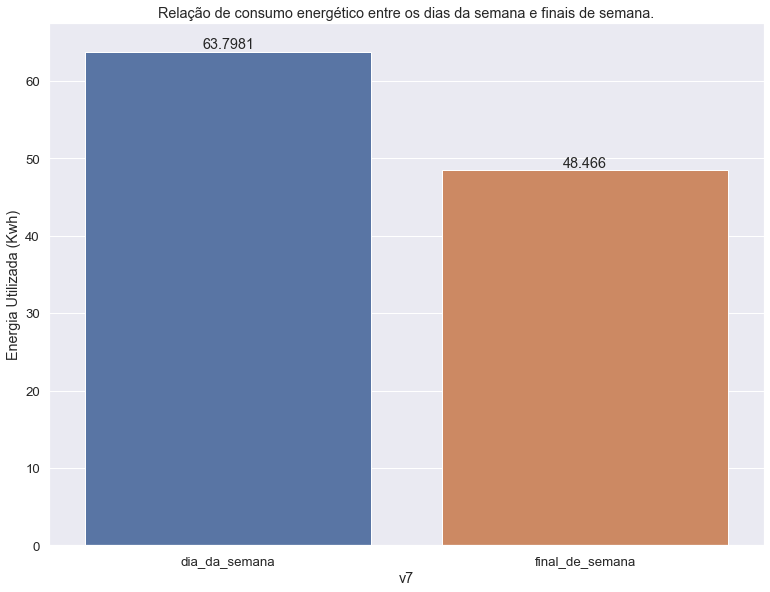

In [80]:
ax = sns.barplot(x=energia_maior_19.v7, y=energia_maior_19.energia_usada, errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('Relação de consumo energético entre os dias da semana e finais de semana.')
plt.ylabel('Energia Utilizada (Kwh)')
plt.show()

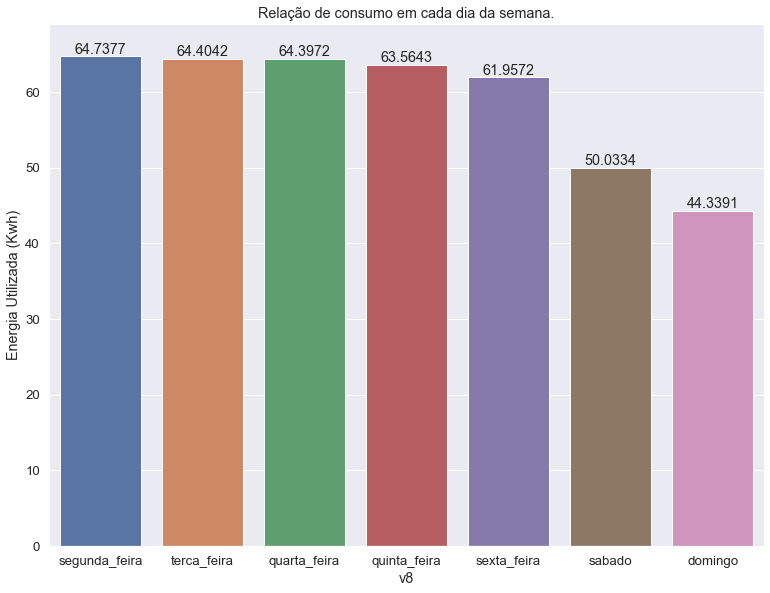

In [81]:
ax = sns.barplot(x=energia_maior_19.v8, y=energia_maior_19.energia_usada, errwidth=0, order=['segunda_feira', 'terca_feira', 'quarta_feira', 'quinta_feira', 'sexta_feira', 'sabado', 'domingo'])
ax.bar_label(ax.containers[0])
plt.ylabel('Energia Utilizada (Kwh)')
plt.title('Relação de consumo em cada dia da semana.')
plt.show()

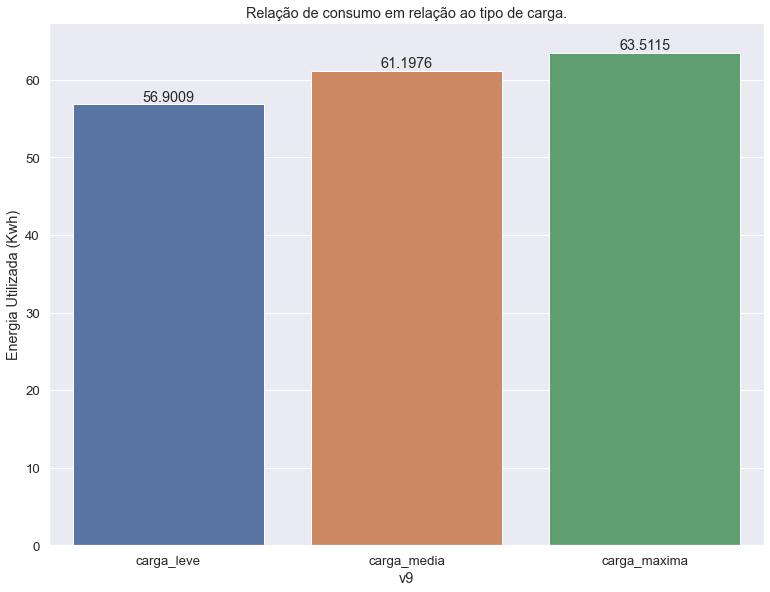

In [82]:
ax = sns.barplot(x=energia_maior_19.v9, y=energia_maior_19.energia_usada, errwidth=0)
ax.bar_label(ax.containers[0])
plt.ylabel('Energia Utilizada (Kwh)')
plt.title('Relação de consumo em relação ao tipo de carga.')
plt.show()

- Existe um consumo de energia constante durante o meio da semana com média de consumo em torno de 64 Kwh, já no final de semana há uma queda no consumo em torno de 20%;
- É visto que a carga máxima é a responsável pela maior demanda energética da empresa, o que era esperado, pois ela é utilizada para alimentar as maiores máquinas da empresa;
- Em seguida, será trabalhado com o dataframe original, sem os outliers, para verificar o comportamento das variáveis em função do tempo (no caso, em meses do ano).

In [83]:
df = df[df['energia_usada'] <= ls] # dataframe original sem os outliers

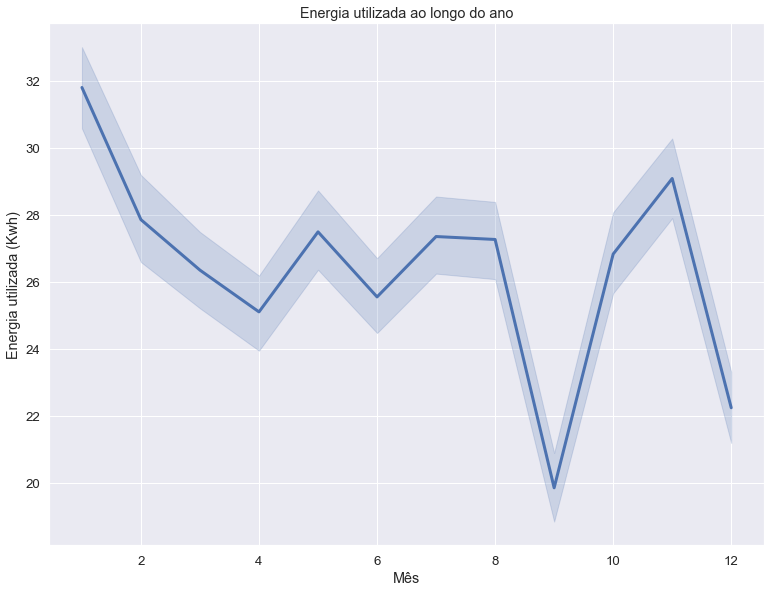

In [84]:
sns.lineplot(x=df.mes, y='energia_usada', data=df, linewidth=3.0)

plt.title('Energia utilizada ao longo do ano')
plt.xlabel('Mês')
plt.ylabel('Energia utilizada (Kwh)')
plt.show()

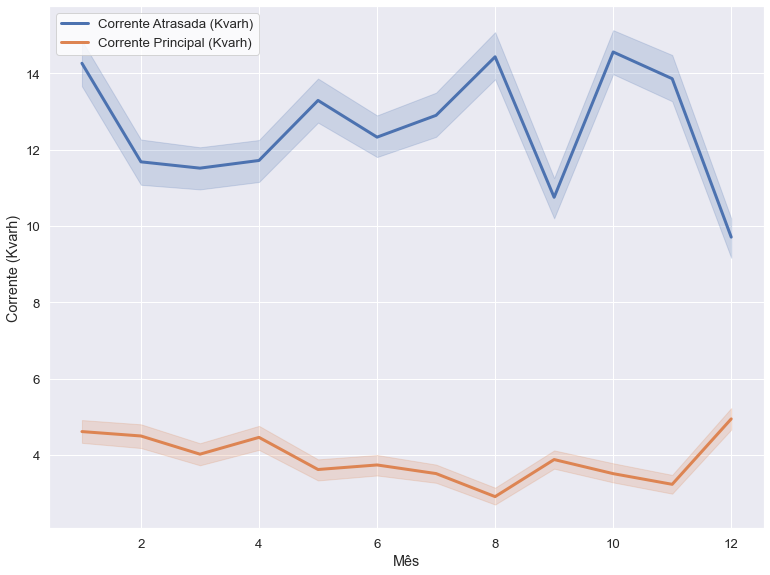

In [85]:
sns.lineplot(x=df.mes, y='v1', data=df, label='Corrente Atrasada (Kvarh)', linewidth=3.0)
sns.lineplot(x=df.mes, y='v2', data=df, label='Corrente Principal (Kvarh)', linewidth=3.0)
plt.legend(facecolor='white')
plt.xlabel('Mês')
plt.ylabel('Corrente (Kvarh)')
plt.show()

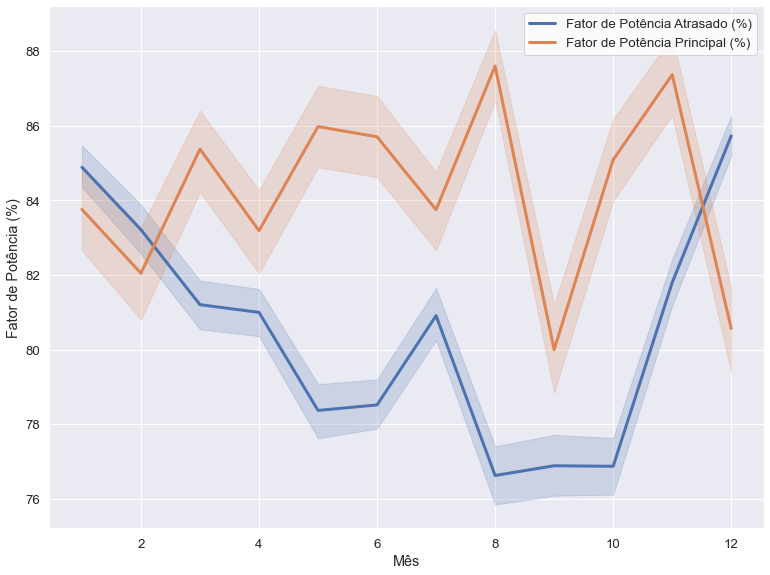

In [86]:
sns.lineplot(x=df.mes, y='v4', data=df, label='Fator de Potência Atrasado (%)', linewidth=3.0)
sns.lineplot(x=df.mes, y='v5', data=df, label='Fator de Potência Principal (%)', linewidth=3.0)
plt.legend(facecolor='white')
plt.xlabel('Mês')
plt.ylabel('Fator de Potência (%)')
plt.show()

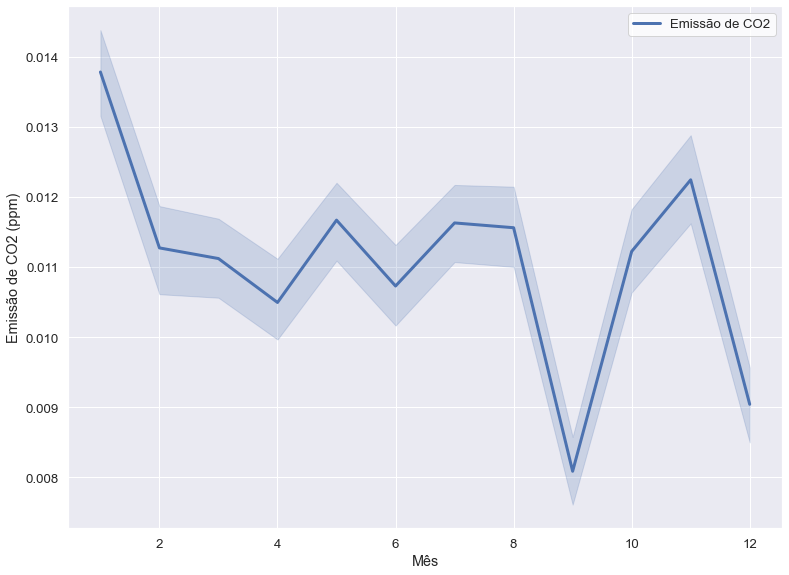

In [87]:
sns.lineplot(x=df.mes, y='v3', data=df, label='Emissão de CO2', linewidth=3.0)
plt.legend(facecolor='white')
plt.xlabel('Mês')
plt.ylabel('Emissão de CO2 (ppm)')
plt.show()

#### Análise dos gráficos em função do tempo (mês a mês)

- No primeiro mês do ano há um pico de utilização de energia elétrica e depois há uma estabilização, com grande redução no mês de setembro e encerra-se o ano com a utilização de cerca de 74% da energia que iniciou o ano.
- Como já visto, há uma grande correlação entre o gasto de energia e a emissão de CO2, então o gráfico de emissão de CO2 segue a mesma tendência do gráfico de utilização de energia;
- As correntes tendem a seguir constantes (na média) ao longo do ano
- Os fatores de potência tem distribuições diferentes, enquanto o atrasado segue a tendência da energia utilizada, o fator de potência principal se mantém constante ao longo do ano;

---

- Sintetizando o que foi visto, agrupou-se os dados por mês em função de suas médias

In [88]:
df.groupby('mes')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean() # agrupando os valores por mês

,energia_usada,v1,v2,v3,v4,v5
mes,,,,,,
1,31.811173,14.264547,4.613738,0.013786,84.890219,83.757637
2,27.865060,11.681698,4.498506,0.011275,83.214211,82.047355
3,26.358088,11.516345,4.021760,0.011124,81.203878,85.375878
4,25.111655,11.717407,4.461942,0.010497,80.997428,83.186263
5,27.500527,13.290924,3.619918,0.011672,78.368848,85.978287
6,25.558794,12.328711,3.739171,0.010732,78.515564,85.703983
7,27.360972,12.900121,3.513395,0.011632,80.909418,83.748328
8,27.273709,14.433824,2.909431,0.011563,76.623990,87.600223
9,19.860336,10.752377,3.880898,0.008088,76.885009,79.997704


- Verificou-se a seguir que durante a semana há um gasto energético de quase 3 vezes o visto no final de semana.

In [89]:
df.groupby('v7')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean()

,energia_usada,v1,v2,v3,v4,v5
v7,,,,,,
dia_da_semana,32.345490,15.762339,2.685035,0.013905,79.787711,90.292413
final_de_semana,11.673521,4.743357,6.937476,0.004065,82.195352,69.170048


- Também percebe-se que não há diferença significativa de consumo energético entre os dias úteis da semana; O sábado indica que há apenas meio turno de trabalho;

In [90]:
df.groupby('v8')[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean()

,energia_usada,v1,v2,v3,v4,v5
v8,,,,,,
domingo,7.545633,3.235633,7.659093,0.002045,82.171675,64.022626
quarta_feira,31.017501,14.914006,3.257195,0.013298,80.426911,87.800438
quinta_feira,33.300788,16.528270,2.411300,0.014448,79.358576,91.671863
sabado,15.805548,6.252593,6.215135,0.006086,82.219054,74.322631
segunda_feira,32.156165,15.661296,2.567039,0.013857,79.507366,90.555187
sexta_feira,32.077437,15.641165,2.648679,0.013809,79.713801,90.713766
terca_feira,33.185994,16.073949,2.541924,0.014115,79.935670,90.722831


- Em seguida, analisou-se os perfis das variáveis em relação ao tipo de carga utilizada

In [91]:
mes_v9 = df.groupby(['mes','v9'])[['energia_usada','v1', 'v2', 'v3', 'v4', 'v5']].mean()
mes_v9.head()

energia_usada         v1        v2        v3         v4  \
mes v9                                                                      
1   carga_leve        16.066696  10.966703  3.683297  0.006321  76.968704   
    carga_maxima      52.082535  21.201778  3.669595  0.023680  92.274912   
    carga_media       48.952868  15.880129  7.198734  0.021705  95.580090   
2   carga_leve         9.319303   6.298180  5.058908  0.002665  76.839722   
    carga_maxima      64.378243  25.620000  0.953356  0.028266  91.233086   

                         v5  
mes v9                       
1   carga_leve    83.721004  
    carga_maxima  90.298732  
    carga_media   79.031951  
2   carga_leve    77.142387  
    carga_maxima  98.245045

In [92]:
leve = mes_v9.iloc[::3,0].values
media = mes_v9.iloc[1::3,0].values
max = mes_v9.iloc[2::3,0].values
meses = range(1,13,1)

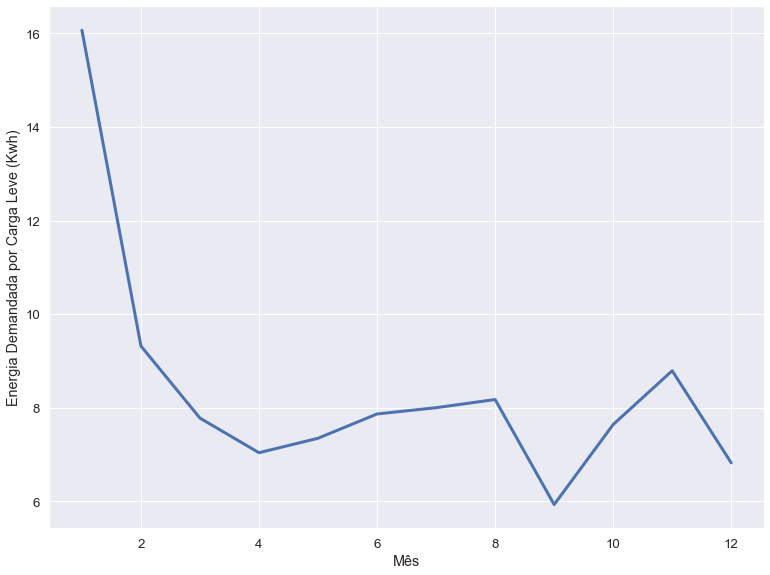

In [93]:
sns.lineplot(x=meses, y=leve, linewidth=3.0)
plt.xlabel('Mês')
plt.ylabel('Energia Demandada por Carga Leve (Kwh)')
plt.show()

- No primeiro mês do ano há uma grande utilização de carga leve na indústria, provavelmente a produção está iniciando e por isso há uma maior demanda por iluminação e equipamentos leves;
- Quanto a carga média, cresce a partir do segundo mês e se mantém constante com queda no último mês do ano, o que pode indicar um período de menor demanda na fábrica; Isso se relaciona com a diminuição do consumo energético visto acima;
- Finalmente, a carga pesada começa em valores próximos a carga média e registra uma queda de cerca de 35% do segundo para o terceiro mês e se mantém constante até subir nos últimos 2 meses de registro (nov-dez).

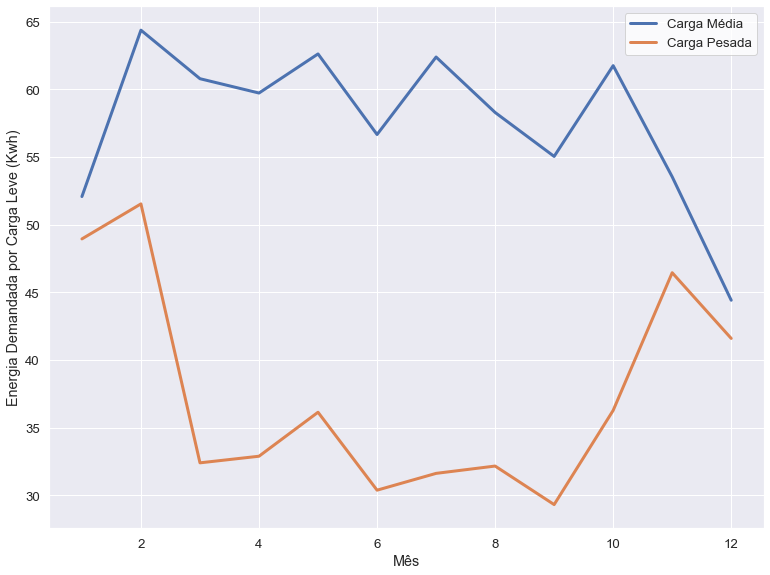

In [94]:
sns.lineplot(x=meses, y=media, label='Carga Média', linewidth=3.0)
sns.lineplot(x=meses, y=max, label='Carga Pesada', linewidth=3.0)
plt.legend(facecolor='white')
plt.xlabel('Mês')
plt.ylabel('Energia Demandada por Carga Leve (Kwh)')
plt.show()

## APÊNDICE

- Tentantiva de entender o comportamento das variáveis de corrente e fator de potência durante o dia e durante o mês de produção para uma indústria de aço

In [95]:
df_dia1 = df[df['data'].dt.day == 1][:96]

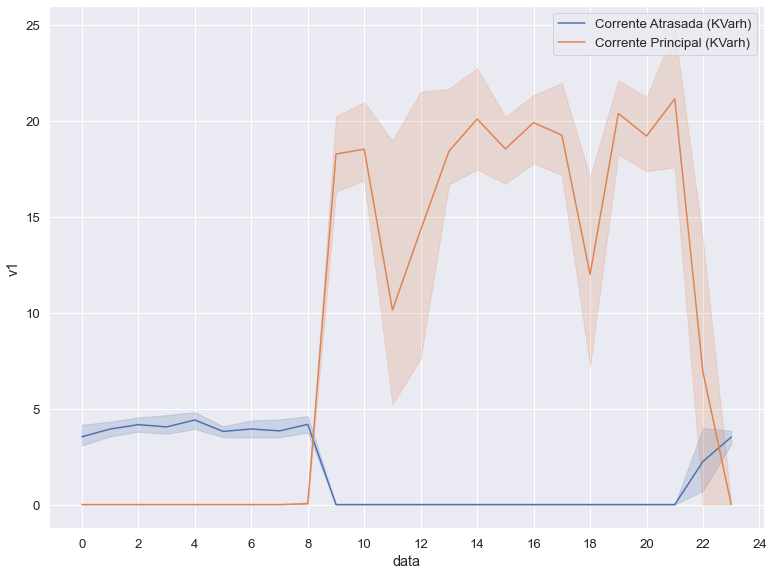

In [97]:
sns.lineplot(x=df_dia1['data'].dt.hour, y='v1', data=df_dia1, label='Corrente Atrasada (KVarh)')
sns.lineplot(x=df_dia1['data'].dt.hour, y='v2', data=df_dia1, label='Corrente Principal (KVarh)')
plt.xticks(np.arange(0, 25, 2))
plt.legend()

plt.show() 

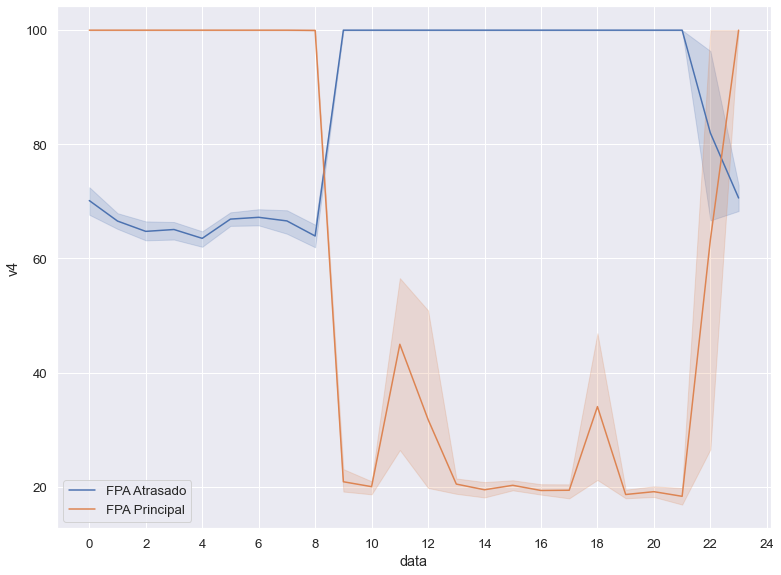

In [107]:
sns.lineplot(x=df_dia1['data'].dt.hour, y='v4', data=df_dia1, label='FPA Atrasado')
sns.lineplot(x=df_dia1['data'].dt.hour, y='v5', data=df_dia1, label='FPA Principal')
plt.xticks(np.arange(0, 25, 2))
plt.legend()

plt.show() 

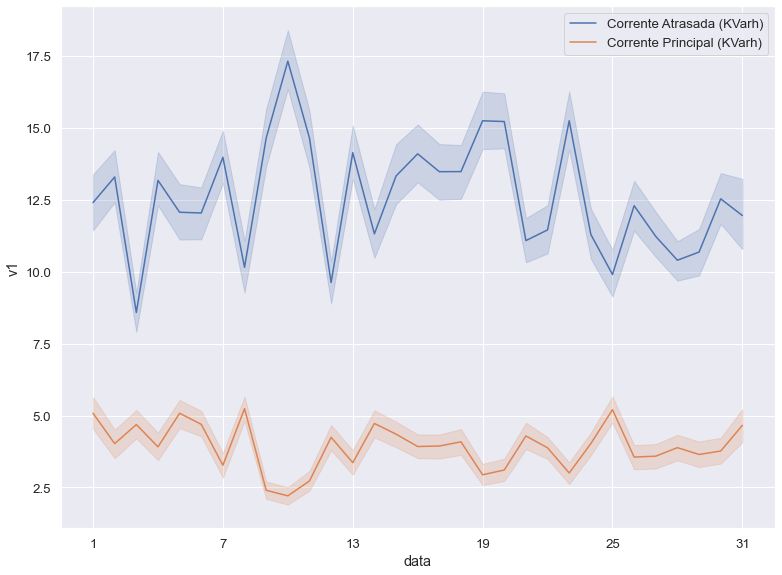

In [104]:
sns.lineplot(x=df['data'].dt.day, y='v1', data=df, label='Corrente Atrasada (KVarh)')
sns.lineplot(x=df['data'].dt.day, y='v2', data=df, label='Corrente Principal (KVarh)')
plt.xticks(np.arange(1, 32, 6))
plt.legend()

plt.show() 

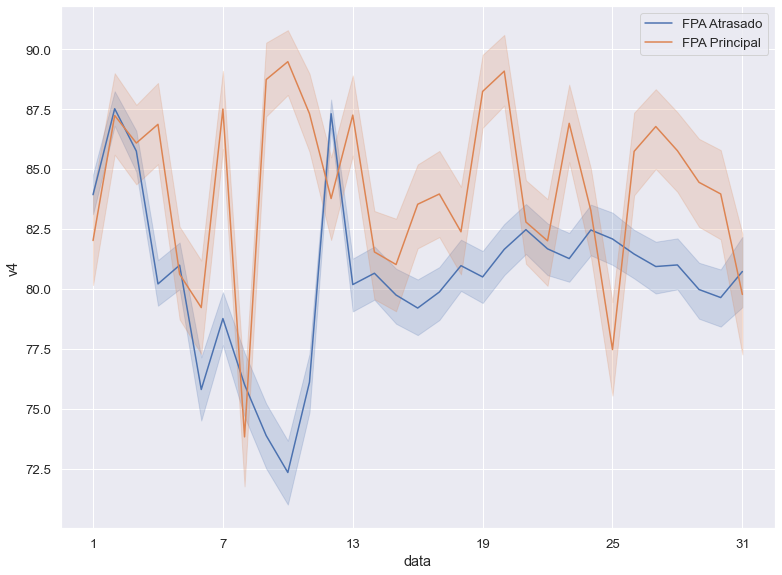

In [106]:
sns.lineplot(x=df['data'].dt.day, y='v4', data=df, label='FPA Atrasado')
sns.lineplot(x=df['data'].dt.day, y='v5', data=df, label='FPA Principal')
plt.xticks(np.arange(1, 32, 6))

plt.legend()

plt.show()

- Durante o expediente, a corrente principal é quem é responsável pela demanda energética dos equipamentos da fábrica, aparentemente o turno começa as 8h e termina as 22h, com dois períodos de intervalo;
- Já o fator principal decaí com o início do expediente, significa que quanto menor o fator principal, mais está sendo demandado de energia; 
- Interessante notar que o fator atrasado decaí para 70% durante o período noturno,  assim como a corrente atrasada possui valores acima de zero durante esse período;

#### Conclusões

- Deve se utilizar uma abordagem para uma modelagem por regressão utilizando, a princípio, excluindo apenas a variável v3, pois ela parece ser uma cópia da variável target;
    - V2 e V5 (corrente principal e fator principal) tem uma correçaão negativa alta, pode ser que a ausência de uma delas não influencie no modelo (TESTAR);
    - Será interessante realizar enconding nas variáveis categórias V7 e V9; 
- O período deve ser analisado com cuidado, pois no início e no fim do ano há flutuações nos dados; 
- Talvez seja melhor agrupar os dados dia a dia, devido as flutuações durante o dia vistos nos gráficos do Apêndice;

### Modelo de Regressão

In [13]:
df['dias_continuos'] = df.data.dt.dayofyear

In [24]:
df['v7'].replace({'dia_da_semana':0, 'final_de_semana':1}, inplace=True)
df['v9'].replace({'carga_leve':0, 'carga_media':1, 'carga_maxima':2}, inplace=True)

In [27]:
df_agrupado = df.groupby('dias_continuos')['energia_usada', 'v1', 'v2', 'v4', 'v5', 'v7', 'v9'].mean()

C:\Users\felip\AppData\Local\Temp\ipykernel_4676\3416042022.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_agrupado = df.groupby('dias_continuos')['energia_usada', 'v1', 'v2', 'v4', 'v5', 'v7', 'v9'].mean()


In [31]:
X = df_agrupado.drop('energia_usada', axis=1)
y = df_agrupado.energia_usada

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=51)

In [33]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (273, 6) (273,)
Testing set shape:  (92, 6) (92,)
